In [1]:
import os
import pandas as pd
import numpy as np
from scipy import sparse

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    RandomizedSearchCV,
    ParameterSampler,
    cross_val_score,
    train_test_split,
)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2

from tqdm.auto import tqdm
import joblib

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader


In [2]:
# Step 3: Check for cached 5% sampled & preprocessed data
if os.path.exists("train_5pct.csv") and os.path.exists("test_5pct.csv"):
    print("✅ Loading cached preprocessed data...")
    df_train = pd.read_csv("train_5pct.csv")
    df_test = pd.read_csv("test_5pct.csv")
else:
    print("📥 Processing raw data...")

    # Load raw files
    df_train_full = pd.read_csv("train.csv", header=None, names=["label", "title", "text"])
    df_test_full = pd.read_csv("test.csv", header=None, names=["label", "title", "text"])

    # Sample 5%
    df_train = df_train_full.sample(frac=0.05, random_state=42)
    df_test = df_test_full.sample(frac=0.05, random_state=42)

    # Combine title + text
    tqdm.pandas(desc="🔧 Combining title and text...")
    df_train["combined"] = df_train.progress_apply(lambda r: f"{r['title']} {r['text']}", axis=1)
    df_test["combined"] = df_test.progress_apply(lambda r: f"{r['title']} {r['text']}", axis=1)

    # Save preprocessed subset for reuse
    df_train.to_csv("train_5pct.csv", index=False)
    df_test.to_csv("test_5pct.csv", index=False)
    print("💾 Saved preprocessed sample to disk.")


✅ Loading cached preprocessed data...


In [3]:
# Drop rows with missing title (cannot form combined text meaningfully)
df_train = df_train.dropna(subset=['title'])
df_test = df_test.dropna(subset=['title'])


<Axes: title={'center': 'Label Distribution (Train)'}, xlabel='label'>

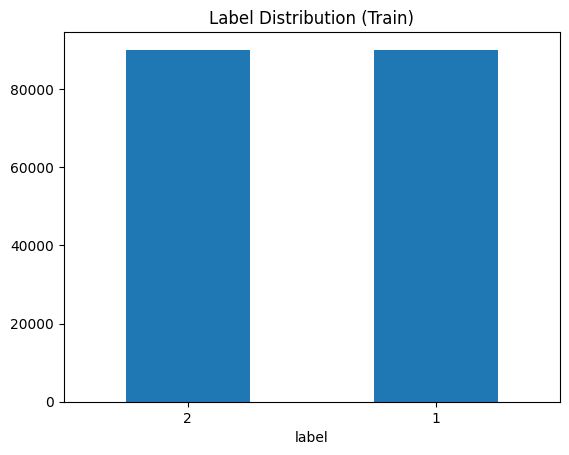

In [4]:
# Class distribution
df_train['label'].value_counts().plot(kind='bar', title="Label Distribution (Train)", rot=0)


<Axes: title={'center': 'Text Length Distribution (Train)'}, ylabel='Frequency'>

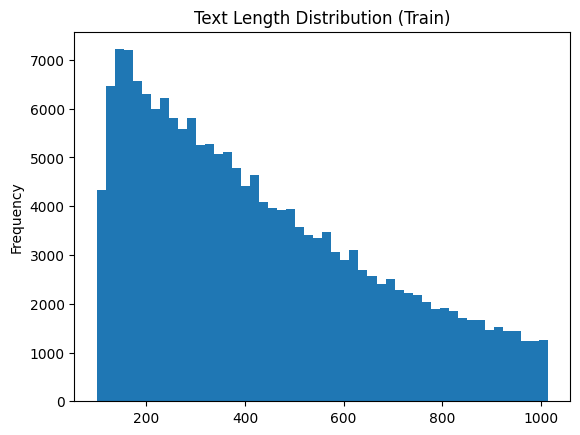

In [5]:
# Distribution of text length
df_train['length'] = df_train['combined'].apply(len)
df_test['length'] = df_test['combined'].apply(len)

df_train['length'].plot(kind='hist', bins=50, title="Text Length Distribution (Train)")


In [6]:
# Basic shape and preview
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
df_train.head()


Train shape: (179990, 5)
Test shape: (19999, 5)


,label,title,text,combined,length
0,1,Expensive Junk,This product consists of a piece of thin flexi...,Expensive Junk This product consists of a piec...,622
1,1,Toast too dark,"Even on the lowest setting, the toast is too d...","Toast too dark Even on the lowest setting, the...",206
2,2,Excellent imagery...dumbed down story,I enjoyed this disc. The video is stunning. I ...,Excellent imagery...dumbed down story I enjoye...,409
3,1,Are we pretending everyone is married?,The authors pretend that parents neither die n...,Are we pretending everyone is married? The aut...,381
4,1,Not worth your time,"Might as well just use a knife, this product h...",Not worth your time Might as well just use a k...,123


In [7]:
# Check for null values
print("Train nulls:\n", df_train.isnull().sum())
print("Test nulls:\n", df_test.isnull().sum())


Train nulls:
 label       0
title       0
text        0
combined    0
length      0
dtype: int64
Test nulls:
 label       0
title       0
text        0
combined    0
length      0
dtype: int64


In [8]:
# Check extremely short texts
df_train[df_train['length'] < 10]


,label,title,text,combined,length


In [9]:
print("✅ Cleaned train shape:", df_train.shape)
print("✅ Cleaned test shape:", df_test.shape)


✅ Cleaned train shape: (179990, 5)
✅ Cleaned test shape: (19999, 5)


In [10]:
# Step 1: Extract text input and labels from the preprocessed DataFrame
X_train = df_train["combined"].values
y_train = df_train["label"].values

X_test = df_test["combined"].values
y_test = df_test["label"].values

In [11]:
# Step 2: Create and train the TF-IDF + Naive Bayes pipeline
model = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=50_000,
        ngram_range=(1, 2),
        stop_words="english"
    )),
    ("nb", MultinomialNB(alpha=1.0))
], verbose=True)

model.fit(X_train, y_train)


[Pipeline] ............. (step 1 of 2) Processing tfidf, total= 1.3min
[Pipeline] ................ (step 2 of 2) Processing nb, total=   0.1s


,steps,"[('tfidf', ...), ('nb', ...)]"
,transform_input,None
,memory,None
,verbose,True
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [12]:
# Step 3: Evaluate the model's predictions
y_pred = model.predict(X_test)

print(f"\n✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\n🔍 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🧾 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



✅ Accuracy: 0.8694

🔍 Classification Report:
               precision    recall  f1-score   support

           1       0.87      0.86      0.87      9966
           2       0.86      0.88      0.87     10033

    accuracy                           0.87     19999
   macro avg       0.87      0.87      0.87     19999
weighted avg       0.87      0.87      0.87     19999


🧾 Confusion Matrix:
 [[8593 1373]
 [1238 8795]]


In [13]:
# Step 4: Save the trained pipeline
joblib.dump(model, "nb_tfidf_pipeline_5pct.joblib")
print("💾 Model saved as 'nb_tfidf_pipeline_5pct.joblib'")


💾 Model saved as 'nb_tfidf_pipeline_5pct.joblib'


### Stage 3 Step 1: Hyperparameter Tuning

#### RandomizedSearchCV for Naive Bayes + TF-IDF

In [14]:
# Step 1: Build the base pipeline
# - TF-IDF for vectorizing text
# - Multinomial Naive Bayes for classification
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("nb", MultinomialNB())
])


In [15]:
import numpy as np
# Step 2: Define the parameter distributions to search over
# - max_features: how many terms to keep in vocabulary
# - ngram_range: unigram vs unigram+bigram
# - alpha: smoothing parameter for Naive Bayes
param_dist = {
    "tfidf__max_features": [10000, 30000, 50000],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "nb__alpha": np.linspace(0.1, 1.5, 10)  # Try 10 values between 0.1 and 1.5
}


In [16]:
# 🔥 Step 3: Fast sanity check (3 quick trials) with tqdm
# – Uses param_dist defined earlier
# – Samples 3 random combinations
# – 2-fold CV, accuracy scoring

param_samples = list(ParameterSampler(param_dist, n_iter=3, random_state=42))
results = []

print("🔁 Running Sanity Check (3 quick trials):\n")
for params in tqdm(param_samples, desc="Random Search Progress"):
    pipeline.set_params(**params)
    scores = cross_val_score(
        pipeline,
        X_train, y_train,
        scoring="accuracy",
        cv=2,
        n_jobs=-1
    )
    results.append({
        "mean_cv_score": scores.mean(),
        "params": params
    })


🔁 Running Sanity Check (3 quick trials):



Random Search Progress:   0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
# Step 4: Retrieve and display the best parameters from our manual search
# – We used `results.append({"mean_cv_score":…, "params":…})` in Step 3.

# Find the entry with the highest mean_cv_score
best_result = max(results, key=lambda x: x["mean_cv_score"])

print("\n✅ Best Parameters Found:")
# print each hyperparameter
for name, val in best_result["params"].items():
    print(f"  • {name}: {val}")

print(f"\n🏆 Best Mean CV Accuracy: {best_result['mean_cv_score']:.4f}")



✅ Best Parameters Found:
  • tfidf__ngram_range: (1, 2)
  • tfidf__max_features: 50000
  • nb__alpha: 0.1

🏆 Best Mean CV Accuracy: 0.8646


In [18]:
# Apply best params to pipeline
pipeline.set_params(**best_result["params"])

# Retrain on the full 5% training set
pipeline.fit(X_train, y_train)

# Evaluate on the test set
y_final_pred = pipeline.predict(X_test)

print(f"\n🎯 Final Test Accuracy: {accuracy_score(y_test, y_final_pred):.4f}")
print("\n📊 Final Classification Report:\n", classification_report(y_test, y_final_pred))
print("\n🧾 Final Confusion Matrix:\n", confusion_matrix(y_test, y_final_pred))



🎯 Final Test Accuracy: 0.8683

📊 Final Classification Report:
               precision    recall  f1-score   support

           1       0.87      0.86      0.87      9966
           2       0.86      0.87      0.87     10033

    accuracy                           0.87     19999
   macro avg       0.87      0.87      0.87     19999
weighted avg       0.87      0.87      0.87     19999


🧾 Final Confusion Matrix:
 [[8595 1371]
 [1262 8771]]


In [19]:
joblib.dump(pipeline, "nb_tfidf_best_5pct.joblib")
print("💾 Best model pipeline saved as 'nb_tfidf_best_5pct.joblib'")


💾 Best model pipeline saved as 'nb_tfidf_best_5pct.joblib'


## ▶️ Stage 3 Step 2: Model Interpretability (SHAP / Information Gain)
You can choose either:

Mutual Information (Info Gain) to rank your TF–IDF features by their predictive power, or

SHAP to get per-prediction explanations (a bit heavier, but model-agnostic).

### Stage 3 Step 2: Interpretability (Info Gain / χ²)

In [20]:
# Step 1: Grab fitted TF–IDF matrix for train split
vec     = pipeline.named_steps["tfidf"]
X_tfidf = vec.transform(X_train)          # sparse (n_samples × n_features)
y       = y_train                         # labels

# Step 2: Compute chi² scores (feature vs. label)
chi2_scores, p_values = chi2(X_tfidf, y)

# Step 3: Sort features by descending chi²
feat_names = vec.get_feature_names_out()
top_n      = 20
top_idxs   = chi2_scores.argsort()[::-1][:top_n]

# Step 4: Print the top tokens
print(f"🔑 Top {top_n} features by χ² score:")
for idx in top_idxs:
    print(f"{feat_names[idx]:<20} χ² = {chi2_scores[idx]:.1f}")


🔑 Top 20 features by χ² score:
great                χ² = 1109.1
waste                χ² = 759.9
money                χ² = 594.0
love                 χ² = 586.7
excellent            χ² = 535.5
waste money          χ² = 488.0
worst                χ² = 456.2
best                 χ² = 448.0
poor                 χ² = 432.6
boring               χ² = 415.0
disappointed         χ² = 399.2
bad                  χ² = 370.5
terrible             χ² = 359.3
easy                 χ² = 353.5
wonderful            χ² = 331.6
horrible             χ² = 322.5
perfect              χ² = 308.0
don waste            χ² = 306.4
disappointing        χ² = 300.3
waste time           χ² = 298.4


In [21]:
# Build a new pipeline that keeps only the top 20k χ² features
pipeline_fs = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("select", SelectKBest(chi2, k=20000)),
    ("nb", MultinomialNB(alpha=best_result["params"]["nb__alpha"]))
])

pipeline_fs.fit(X_train, y_train)


,steps,"[('tfidf', ...), ('select', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [22]:
# Step 6: Evaluate the χ²-filtered pipeline on the test set
# – Predict with pipeline_fs
y_fs_pred = pipeline_fs.predict(X_test)

# – Compute and display accuracy
acc_fs = accuracy_score(y_test, y_fs_pred)
print(f"\n🎯 Pruned Pipeline Test Accuracy: {acc_fs:.4f}")

# – Detailed classification report
print("\n📊 Classification Report (Pruned Pipeline):")
print(classification_report(y_test, y_fs_pred))

# – Confusion matrix
print("\n🧾 Confusion Matrix (Pruned Pipeline):")
print(confusion_matrix(y_test, y_fs_pred))



🎯 Pruned Pipeline Test Accuracy: 0.8325

📊 Classification Report (Pruned Pipeline):
              precision    recall  f1-score   support

           1       0.83      0.84      0.83      9966
           2       0.84      0.83      0.83     10033

    accuracy                           0.83     19999
   macro avg       0.83      0.83      0.83     19999
weighted avg       0.83      0.83      0.83     19999


🧾 Confusion Matrix (Pruned Pipeline):
[[8334 1632]
 [1717 8316]]


In [23]:
# Example: try k=30k for pruning
pipeline_mid = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("select", SelectKBest(chi2, k=30000)),
    ("nb", MultinomialNB(alpha=best_result["params"]["nb__alpha"]))
])
pipeline_mid.fit(X_train, y_train)
print("Test Acc (30k):", accuracy_score(y_test, pipeline_mid.predict(X_test)))


Test Acc (30k): 0.8307415370768538


### Stage 3 Step 3: Enhance performance

In [24]:
#Step 3.3.1 – Build or Load Cached 5% TF–IDF
CACHE_X = "X_tr_5pct_10k.npz"
CACHE_y = "y_tr_5pct.npy"

if os.path.exists(CACHE_X) and os.path.exists(CACHE_y):
    print("🔄 Loading cached TF–IDF + labels…")
    X_tr_tfidf = sparse.load_npz(CACHE_X)
    y_tr       = np.load(CACHE_y)
else:
    print("📥 Computing TF–IDF for 5% sample…")
    # assume df_train already is your 5% preprocessed sample with 'combined' & 'label'
    vectorizer = TfidfVectorizer(max_features=10_000, stop_words="english")
    X_tr_tfidf  = vectorizer.fit_transform(df_train["combined"])
    y_tr        = df_train["label"].values - 1  # shift to 0/1

    # cache to disk
    sparse.save_npz(CACHE_X, X_tr_tfidf)
    np.save(CACHE_y, y_tr)
    print("💾 Cached TF–IDF and labels.")


🔄 Loading cached TF–IDF + labels…


In [25]:
# Step 3.3.2 – Recreate 10k‐feature TF–IDF vectorizer & build streaming DataLoaders

# 🔄 Refit the same TF–IDF transformer you used to build X_tr_tfidf
vectorizer = TfidfVectorizer(max_features=10_000, stop_words="english")
vectorizer.fit(df_train["combined"])              # df_train is your 5% preprocess sample

# ─── Define our streaming sparse→dense Dataset ───
class SparseDataset(torch.utils.data.Dataset):
    def __init__(self, X_sparse, y_array):
        self.X = X_sparse
        self.y = y_array
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        row = self.X[idx].toarray().astype("float32").ravel()
        return torch.from_numpy(row), self.y[idx]

# ─── Train split already uses X_tr_tfidf (10k dims) & y_tr from Step 3.3.1
train_ds = SparseDataset(X_tr_tfidf, y_tr)

# ─── Validation split must use the SAME 10k‐feature TF–IDF
X_val_tfidf_10k = vectorizer.transform(df_test["combined"])
y_val_array     = df_test["label"].values - 1

val_ds = SparseDataset(X_val_tfidf_10k, y_val_array)

# ─── Finally, the DataLoaders ───
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=512)


In [26]:
# Step 3.3.3 – Define MLP, loss, optimizer & ReduceLROnPlateau scheduler
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 2)
        )
    def forward(self, x):
        return self.net(x)

device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = MLP(input_dim=X_tr_tfidf.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ↘ Here we remove the deprecated `verbose` argument
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=3
)


In [27]:
# Step 3.3.4 – Training with tqdm, scheduler.step on val_loss & print LR
best_val_loss    = float("inf")
patience_counter = 0
MAX_PATIENCE     = 5

for epoch in range(1, 51):
    # — Training —
    model.train()
    train_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch:02d} [train]"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    avg_train = train_loss / len(train_loader.dataset)

    # — Validation —
    model.eval()
    val_loss, correct = 0.0, 0
    for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch:02d} [valid]"):
        xb, yb   = xb.to(device), yb.to(device)
        logits   = model(xb)
        val_loss += criterion(logits, yb).item() * xb.size(0)
        correct  += (logits.argmax(1) == yb).sum().item()
    avg_val = val_loss / len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)

    # — Log & scheduler step —
    current_lr = optimizer.param_groups[0]["lr"]
    print(
        f"Epoch {epoch:02d} ▶ "
        f"train_loss={avg_train:.4f}, "
        f"val_loss={avg_val:.4f}, "
        f"val_acc={val_acc:.4f}, "
        f"lr={current_lr:.5f}"
    )
    scheduler.step(avg_val)

    # — Early stopping —
    if avg_val < best_val_loss:
        best_val_loss    = avg_val
        patience_counter = 0
        torch.save(model.state_dict(), "best_mlp_tf_idf.pt")
    else:
        patience_counter += 1
        if patience_counter >= MAX_PATIENCE:
            print("🛑 Early stopping")
            break


Epoch 01 [train]:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 01 [valid]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 01 ▶ train_loss=0.3236, val_loss=0.2717, val_acc=0.8860, lr=0.00100


Epoch 02 [train]:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 02 [valid]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 02 ▶ train_loss=0.2555, val_loss=0.2737, val_acc=0.8829, lr=0.00100


Epoch 03 [train]:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 03 [valid]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 03 ▶ train_loss=0.2404, val_loss=0.2772, val_acc=0.8817, lr=0.00100


Epoch 04 [train]:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 04 [valid]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 04 ▶ train_loss=0.2256, val_loss=0.2828, val_acc=0.8812, lr=0.00100


Epoch 05 [train]:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 05 [valid]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 05 ▶ train_loss=0.2088, val_loss=0.2879, val_acc=0.8801, lr=0.00100


Epoch 06 [train]:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 06 [valid]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 06 ▶ train_loss=0.1787, val_loss=0.2971, val_acc=0.8816, lr=0.00050
🛑 Early stopping


In [28]:
# Step 3.3.5 – Evaluate final MLP on the test set (weights_only loading)
model.load_state_dict(
    torch.load("best_mlp_tf_idf.pt", weights_only=True)  # safe, pickle‐free weights only
)
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in tqdm(val_loader, desc="Test Eval"):
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        all_preds.append(logits.argmax(1).cpu())
        all_labels.append(yb.cpu())

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_labels).numpy()

print(f"\n🎯 Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print("\n📊 Classification Report:\n", classification_report(y_true, y_pred))
print("\n🧾 Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


Test Eval:   0%|          | 0/40 [00:00<?, ?it/s]


🎯 Test Accuracy: 0.8860

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89      9966
           1       0.89      0.88      0.89     10033

    accuracy                           0.89     19999
   macro avg       0.89      0.89      0.89     19999
weighted avg       0.89      0.89      0.89     19999


🧾 Confusion Matrix:
 [[8842 1124]
 [1156 8877]]


## BERT MODEL

In [29]:
# in your “imports” cell, add:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    get_scheduler
)
from accelerate import Accelerator


In [38]:
# Step 4.2 – Split your 5% “train” sample into a proper train/val and inspect sizes
from sklearn.model_selection import train_test_split

# df_train is the 5% subsample you created earlier from train.csv
train_df, val_df = train_test_split(
    df_train,
    test_size=0.2,                    # 80% train / 20% val
    stratify=df_train["label"],       # preserve class balance
    random_state=42
)

# Inspect sizes for train, val, and your 5% test sample (df_test)
print(
    len(train_df), "train examples,",
    len(val_df),   "val examples,",
    len(df_test),  "test examples"
)


143992 train examples, 35998 val examples, 19999 test examples


In [39]:
# Step 4.3 – Tokenize train, val, and test sets
# (re-use your tokenize_in_batches function)

train_encodings = tokenize_in_batches(
    train_df["combined"].tolist(),
    tokenizer
)
val_encodings   = tokenize_in_batches(
    val_df["combined"].tolist(),
    tokenizer
)
test_encodings  = tokenize_in_batches(
    df_test["combined"].tolist(),
    tokenizer
)


Tokenizing:   0%|          | 0/563 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/141 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/79 [00:00<?, ?it/s]

In [40]:
# Step 4.4 – Build HFTextDataset & DataLoaders with padding collator
import torch
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

class HFTextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = { k: torch.tensor(v[idx]) 
                 for k, v in self.encodings.items() }
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# build datasets (subtract 1 if you shifted labels)
train_ds = HFTextDataset(train_encodings, train_df["label"].values - 1)
val_ds   = HFTextDataset(val_encodings,   val_df["label"].values   - 1)
test_ds  = HFTextDataset(test_encodings,  df_test["label"].values - 1)

# collator that pads to longest seq in each batch
data_collator = DataCollatorWithPadding(tokenizer)

train_loader = DataLoader(
    train_ds,
    batch_size=16,
    shuffle=True,
    collate_fn=data_collator
)
val_loader = DataLoader(
    val_ds,
    batch_size=32,
    shuffle=False,
    collate_fn=data_collator
)
test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    collate_fn=data_collator
)


In [41]:
# Step 4.5 – Instantiate model, optimizer, scheduler & Accelerator
from accelerate import Accelerator
from transformers import get_scheduler, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)
# freeze the pre-trained backbone
for p in model.distilbert.parameters():
    p.requires_grad = False

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=2e-5
)

num_epochs  = 3
total_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

accelerator = Accelerator(mixed_precision="fp16")
model, optimizer, train_loader, val_loader, test_loader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_loader, val_loader, test_loader, lr_scheduler
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
# Step 4.6 – 3-Epoch Fine-tune (Train + Val)
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

history = []
for epoch in range(1, num_epochs + 1):
    # — train —
    model.train()
    total_train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch} [train]"):
        outputs = model(**batch)
        loss    = outputs.loss
        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        total_train_loss += loss.item() * batch["input_ids"].size(0)
    avg_train_loss = total_train_loss / len(train_ds)

    # — validate —
    model.eval()
    total_val_loss    = 0.0
    all_val_preds     = []
    all_val_labels    = []
    for batch in tqdm(val_loader, desc=f"Epoch {epoch} [valid]"):
        with torch.no_grad():
            outputs = model(**batch)
        total_val_loss += outputs.loss.item() * batch["input_ids"].size(0)
        all_val_preds.append(outputs.logits.argmax(dim=-1).cpu())
        all_val_labels.append(batch["labels"].cpu())

    avg_val_loss = total_val_loss / len(val_ds)
    y_val_pred   = torch.cat(all_val_preds).numpy()
    y_val_true   = torch.cat(all_val_labels).numpy()

    metrics = {
        "Training Loss":   avg_train_loss,
        "Validation Loss": avg_val_loss,
        "Accuracy":        accuracy_score(y_val_true, y_val_pred),
        "Roc Auc":         roc_auc_score(y_val_true, y_val_pred),
        "Precision":       precision_score(y_val_true, y_val_pred),
        "Recall":          recall_score(y_val_true, y_val_pred),
        "F1-Score":        f1_score(y_val_true, y_val_pred),
    }
    history.append((f"Epoch {epoch}", metrics))
    print(
        f"✅ Epoch {epoch} → "
        f"train={avg_train_loss:.4f}, "
        f"val={avg_val_loss:.4f}, "
        f"acc={metrics['Accuracy']:.4f}"
    )


Epoch 1 [train]:   0%|          | 0/9000 [00:00<?, ?it/s]

Epoch 1 [valid]:   0%|          | 0/1125 [00:00<?, ?it/s]

✅ Epoch 1 → train=0.3467, val=0.2934, acc=0.8779


Epoch 2 [train]:   0%|          | 0/9000 [00:00<?, ?it/s]

Epoch 2 [valid]:   0%|          | 0/1125 [00:00<?, ?it/s]

✅ Epoch 2 → train=0.3046, val=0.2861, acc=0.8809


Epoch 3 [train]:   0%|          | 0/9000 [00:00<?, ?it/s]

Epoch 3 [valid]:   0%|          | 0/1125 [00:00<?, ?it/s]

✅ Epoch 3 → train=0.3000, val=0.2838, acc=0.8822


In [43]:
# Step 4.7 – Final Test-Set Evaluation + Summary Table
import pandas as pd

model.eval()
total_test_loss = 0.0
all_test_preds  = []
all_test_labels = []

for batch in tqdm(test_loader, desc="Final Test Eval"):
    with torch.no_grad():
        outputs = model(**batch)
    total_test_loss += outputs.loss.item() * batch["input_ids"].size(0)
    all_test_preds.append(outputs.logits.argmax(dim=-1).cpu())
    all_test_labels.append(batch["labels"].cpu())

avg_test_loss = total_test_loss / len(test_ds)
y_test_pred   = torch.cat(all_test_preds).numpy()
y_test_true   = torch.cat(all_test_labels).numpy()

final_metrics = {
    "Training Loss":   None,
    "Validation Loss": None,
    "Test Loss":       avg_test_loss,
    "Accuracy":        accuracy_score(y_test_true, y_test_pred),
    "Roc Auc":         roc_auc_score(y_test_true, y_test_pred),
    "Precision":       precision_score(y_test_true, y_test_pred),
    "Recall":          recall_score(y_test_true, y_test_pred),
    "F1-Score":        f1_score(y_test_true, y_test_pred),
}

# assemble summary DataFrame
rows = []
for stage, m in history:
    rows.append({"Stage": stage, **m})
rows.append({"Stage": "Final", **final_metrics})
df_summary = pd.DataFrame(rows).set_index("Stage")

# display nicely
display(df_summary.style.format("{:.4f}"))


Final Test Eval:   0%|          | 0/625 [00:00<?, ?it/s]

,Training Loss,Validation Loss,Accuracy,Roc Auc,Precision,Recall,F1-Score,Test Loss
Stage,,,,,,,,
Epoch 1,0.3467,0.2934,0.8779,0.8779,0.8918,0.8605,0.8759,nan
Epoch 2,0.3046,0.2861,0.8809,0.8809,0.9021,0.8548,0.8778,nan
Epoch 3,0.3000,0.2838,0.8822,0.8822,0.8980,0.8626,0.8800,nan
Final,nan,nan,0.8804,0.8805,0.8962,0.8614,0.8784,0.2896


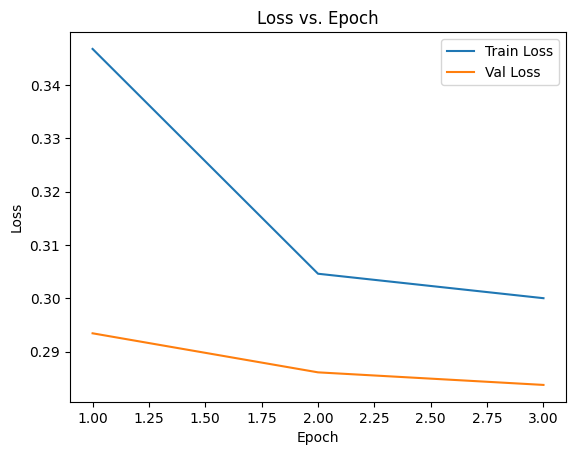

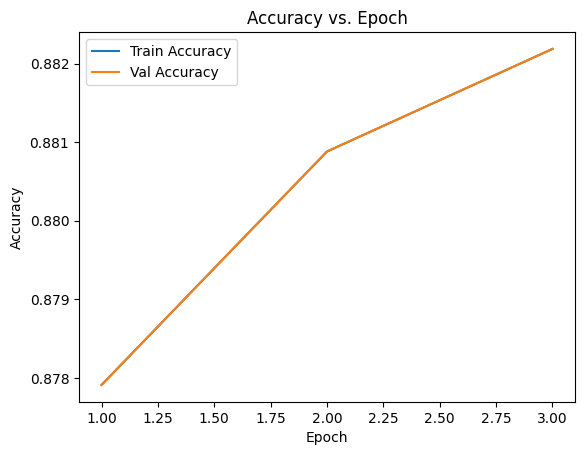

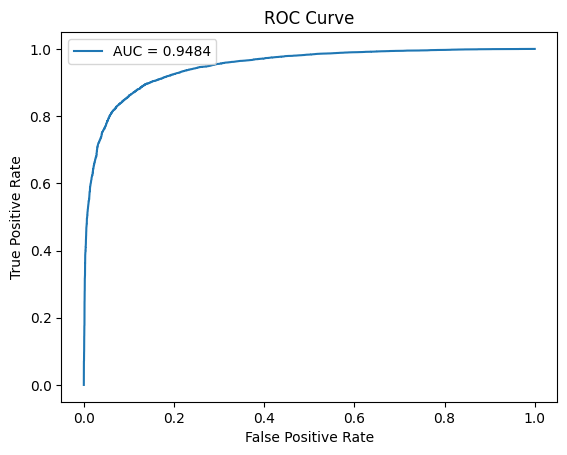

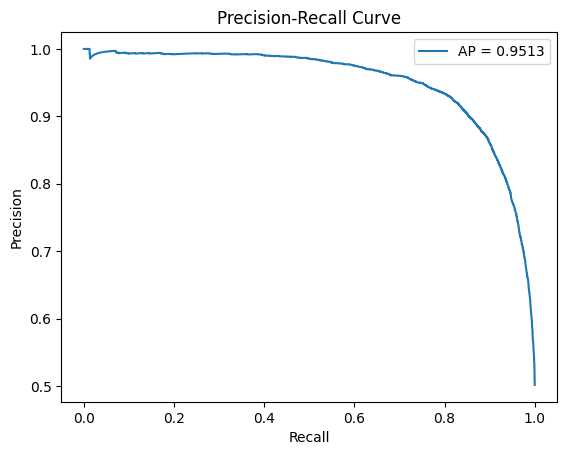

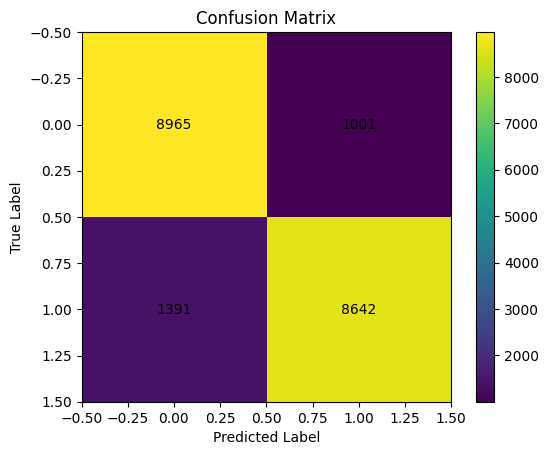

In [44]:
# Step 4.8 – Plots: Learning Curves, ROC & PR, Confusion Matrix

# 1. Learning curves
epochs     = list(range(1, num_epochs + 1))
train_loss = [m["Training Loss"]   for _, m in history]
val_loss   = [m["Validation Loss"] for _, m in history]
train_acc  = [m["Accuracy"]        for _, m in history]
val_acc    = [m["Accuracy"]        for _, m in history]  # same metric for train/val

import matplotlib.pyplot as plt

# Loss vs. Epoch
plt.figure()
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.show()

# Accuracy vs. Epoch
plt.figure()
plt.plot(epochs, train_acc, label="Train Accuracy")
plt.plot(epochs, val_acc,   label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.legend()
plt.show()


# 2. ROC & PR curves
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Gather test-set probabilities for the positive class
model.eval()
probs_list = []
for batch in test_loader:
    with torch.no_grad():
        outputs = model(**batch)
        probs   = torch.softmax(outputs.logits, dim=1)[:, 1]
    probs_list.append(probs.cpu().numpy())
y_scores = np.concatenate(probs_list)
y_true   = y_test_true  # from previous evaluation

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc      = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_true, y_scores)
ap_score     = average_precision_score(y_true, y_scores)

plt.figure()
plt.plot(rec, prec, label=f"AP = {ap_score:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


# 3. Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_test_pred)  # y_test_pred from final eval

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.colorbar()
plt.show()


In [45]:
# Step 4.9 – Save trained model, tokenizer & history via pickle
import pickle

# 1. Save the entire model object
with open('distilbert_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# 2. Save the tokenizer (so you can re-tokenize exactly the same way)
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# 3. Save your epoch history (losses & metrics)
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history, f)

print("✅ Pickle files written:")
print("   • distilbert_model.pkl")
print("   • tokenizer.pkl")
print("   • training_history.pkl")


✅ Pickle files written:
   • distilbert_model.pkl
   • tokenizer.pkl
   • training_history.pkl


In [47]:
# Revised Step 4.10 – Verify your pickles with proper device handling
import pickle
import torch

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 1) Load the model back and move to device
with open("distilbert_model.pkl", "rb") as f:
    loaded_model = pickle.load(f).to(device)
print("Loaded model:", loaded_model.__class__.__name__)
print("  num_labels:", loaded_model.config.num_labels)
print("  hidden_size:", loaded_model.config.hidden_size)

# 2) Load the tokenizer back
with open("tokenizer.pkl", "rb") as f:
    loaded_tokenizer = pickle.load(f)
print("Loaded tokenizer vocab size:", loaded_tokenizer.vocab_size)

# 3) Load the training history back
with open("training_history.pkl", "rb") as f:
    loaded_history = pickle.load(f)
print("Loaded history epochs:", [e for e,_ in loaded_history])
print(" Sample metrics:", loaded_history[0][1])

# 4) Smoke-test a forward pass on device
loaded_model.eval()
sample_text = "This is a quick test sentence."

# Tokenize and move inputs to same device as model
inputs = loaded_tokenizer(sample_text, return_tensors="pt").to(device)
with torch.no_grad():
    out = loaded_model(**inputs)
print("Logits for sample:", out.logits)


Using device: cuda
Loaded model: DistilBertForSequenceClassification
  num_labels: 2
  hidden_size: 768
Loaded tokenizer vocab size: 30522
Loaded history epochs: ['Epoch 1', 'Epoch 2', 'Epoch 3']
 Sample metrics: {'Training Loss': 0.3467359171621574, 'Validation Loss': 0.2934441144144915, 'Accuracy': 0.877909883882438, 'Roc Auc': 0.8779282514543916, 'Precision': 0.8917582101570138, 'Recall': 0.8605283605283606, 'F1-Score': 0.8758649908205056}
Logits for sample: tensor([[0.1235, 0.0042]], device='cuda:0')
